In [2]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
# Normalize between 0 and 1, then multiply by 255
def normalize_img(image):
    image = image.astype(float)
    #image += 1000
    image -= np.amin(image.astype(float))
    image /= np.amax(image)
    return image * 255

In [5]:
# Adaptive sigmoid to remove noisy backgrounds
def sigmoid_adjustment(image, std_dev_mult=1.5, alpha=.5):
    # Calculate the mean and standard deviation of the pixel values
    mean_val = np.mean(image)
    std_dev = np.std(image)

    # Set the midpoint for the sigmoid function to 1 standard deviation above the mean
    midpoint = mean_val + std_dev * std_dev_mult

    # Apply the sigmoid function to adjust image contrast
    # 'alpha' controls the steepness of the sigmoid curve
    adjusted_image = 1 / (1 + np.exp(-alpha * (image - midpoint)))

    # Scale back to 0-255 and convert to uint8
    adjusted_image = np.uint8(255 * (adjusted_image - adjusted_image.min()) / (adjusted_image.max() - adjusted_image.min()))

    return adjusted_image

In [101]:
# Helper functions to add/remove padding
def add_padding(img, pad_width):
    return np.pad(img, pad_width, mode='constant', constant_values=0)

def remove_padding(img, pad_width):
    return img[pad_width:-pad_width, pad_width:-pad_width] if pad_width > 0 else img

In [104]:
def scale_to_uint8(img):
    return ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)

In [113]:
def log_scale(img):
    img = np.clip(img, a_min=1, a_max=None)  # Avoid log(0)
    return (np.log(img) / np.log(img.max()) * 255).astype(np.uint8)


In [114]:
def resize_stack(input_stack, new_size=(512, 512), kernel_size=5):
    assert len(new_size) == 2, "new_size must be a len=2 tuple or list."

    # Pre-allocate the resized array with the new dimensions
    resized_stack = np.zeros((input_stack.shape[0], input_stack.shape[1], new_size[1], new_size[0]), dtype=input_stack.dtype)

    # Adjust pad_width to account for larger kernels properly
    pad_width = kernel_size // 2

    # Iterate over each timepoint and each slice
    for t in range(input_stack.shape[0]):  # Loop over timepoints
        for z in range(input_stack.shape[1]):  # Loop over slices
            # COnvert to np.uint8, then resize slice and add it to new array
            slice = log_scale(input_stack[t, z])
            slice = add_padding(slice, pad_width)
            slice = cv2.medianBlur(slice, ksize=kernel_size)
            slice = remove_padding(slice, pad_width)
            resized_stack[t,z] = cv2.resize(slice, new_size, interpolation=cv2.INTER_LINEAR)

    return resized_stack

In [123]:
# Load image stack
stack = io.imread('stacks/exp240202_01_E.tif')


In [125]:
# Resize stack slices
resized_stack = resize_stack(stack, (512, 512), 9)
# Delete original stack to save memory
del stack

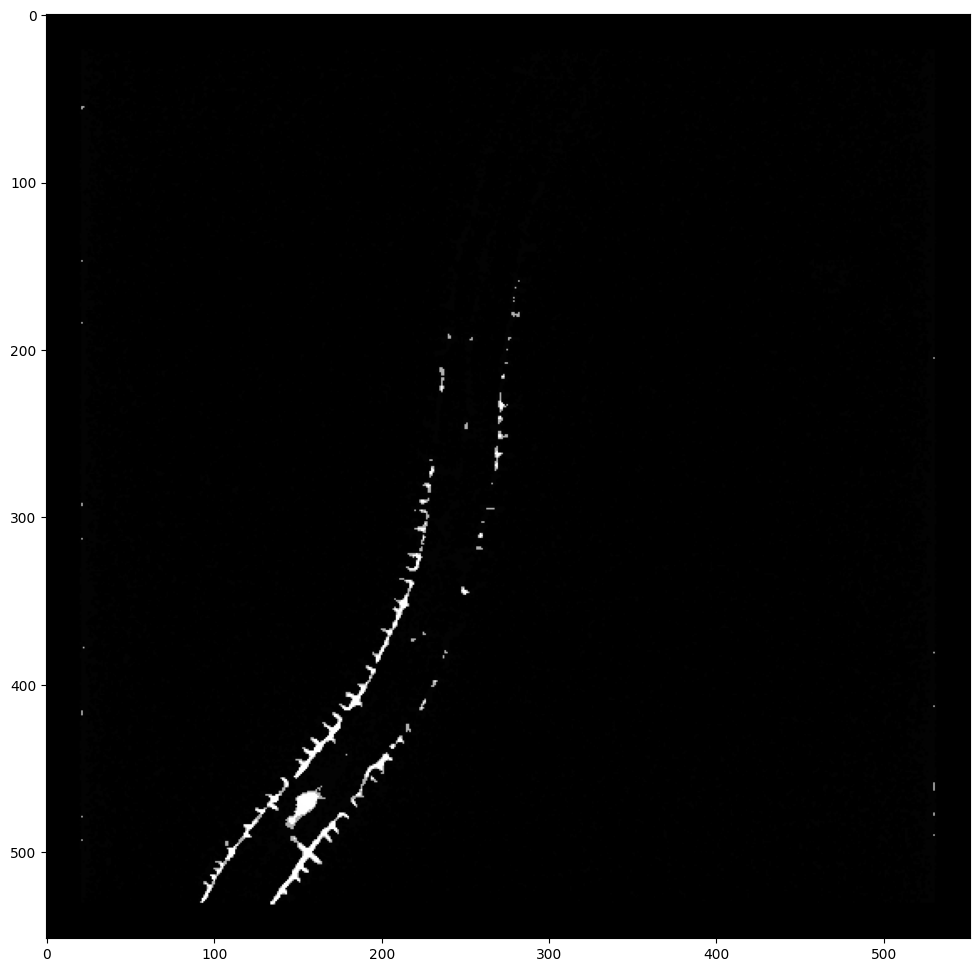

In [132]:
pad_width = 10

#test = remove_padding(resized_stack[0,12,:,:], pad_width)
test = sigmoid_adjustment(resized_stack[0,12,:,:], 3, 5)
test = add_padding(test, 20)
#test = cv2.medianBlur(test, ksize=5) 
#test = remove_padding(test, pad_width)
#enhanced_image = sigmoid_adjustment(test, 3.5, 2)



# Preview image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(test, cmap='gray')

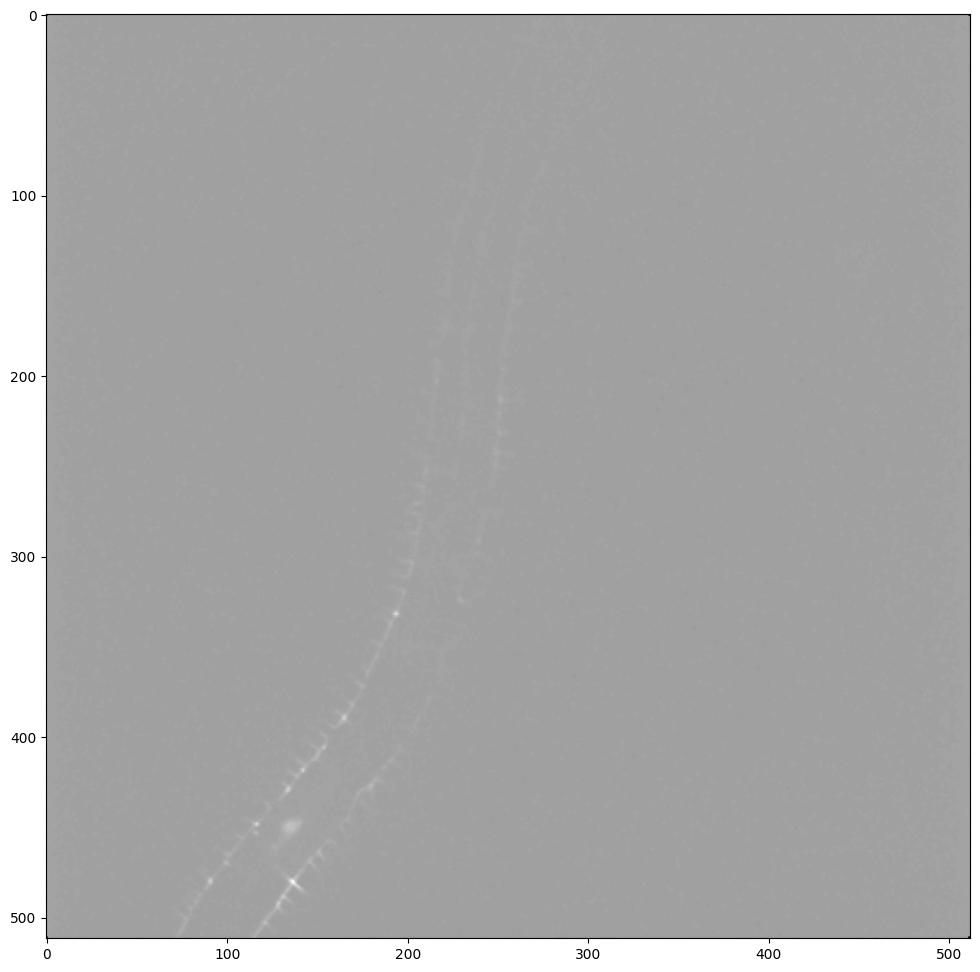

In [133]:
# Preview a slice
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(resized_stack[0,12,:,:], cmap='gray')

In [252]:
# Set threshold between 0-255
threshold = 4
# List to store slices
timepoint_stack = []
image_stack = []

for ii in range(resized_stack.shape[0]):
    for kk in range(16, resized_stack.shape[1]-88):
        # Create thresholded mask
        mask = add_padding(resized_stack[ii,kk,:,:], pad_width)
        mask = cv2.medianBlur(mask, ksize=3)  # ksize is the kernel size, must be an odd number
        mask = remove_padding(mask, pad_width)
        mask = sigmoid_adjustment(mask, 3.5, 2)

        # Normalize mask and target between 0-255
        mask = normalize_img(mask)
        target = normalize_img(resized_stack[ii,kk,:,:])

        # Binarize mask
        blank = np.ones_like(mask)
        binary_mask = np.where(mask > threshold, blank, 0)

        # Mask target slice
        processed_slice = target * binary_mask

        # Add processed slice to stack
        image_stack.append(processed_slice)

    # Add processed stack to timepoint stack    
    timepoint_stack.append(image_stack)
    # Reset image stack for next timepoint
    image_stack = []

# Convert to numpy array
image_stack = np.stack(timepoint_stack, axis=0)

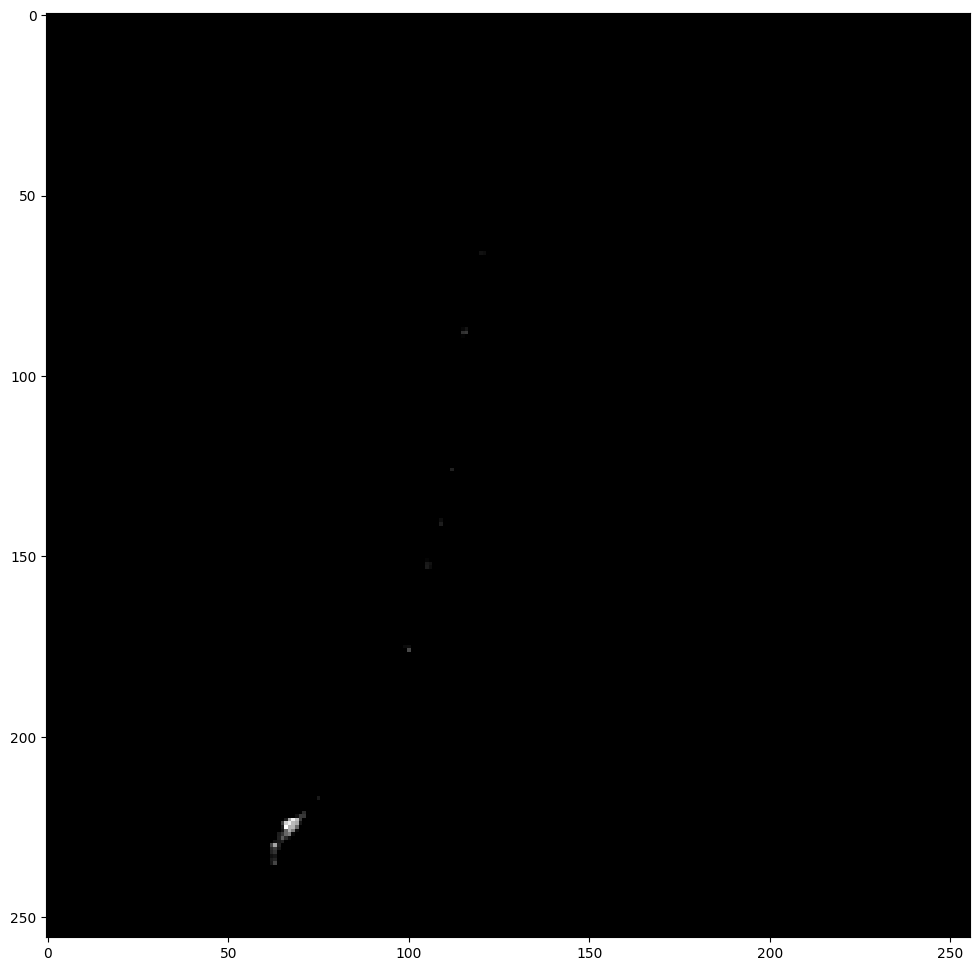

In [253]:
# Check processed slice
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image_stack[0,12,:,:], cmap='gray')

In [254]:
image_stack.shape

(4, 84, 256, 256)

In [255]:
# Prepare data for plotting
image_stack = np.transpose(image_stack[0], (1, 2, 0))
x, y, z = image_stack.shape

Y, X, Z = np.meshgrid(np.arange(y), np.arange(x), np.arange(z))

colors = image_stack.ravel()  # Flatten the color intensity values

# Separate visible and invisible points
visible_mask = colors != 0

# Create a 3D scatter plot
fig = go.Figure()

# Visible points
fig.add_trace(go.Scatter3d(
    x=X.ravel()[visible_mask],
    y=Y.ravel()[visible_mask],
    z=Z.ravel()[visible_mask],
    mode='markers',
    marker=dict(
        size=1,
        color=colors[visible_mask],  # Color based on intensity
        colorscale='Viridis',
        opacity=0.5
    )
))

# Update layout for better viewing
fig.update_layout(
    title='3D Scatter Plot of Image Stack with Conditionally Invisible Points',
    scene=dict(
        xaxis_title='X (pixels)',
        yaxis_title='Y (pixels)',
        zaxis_title='Z (image index)'
    ),
    autosize=False,
    width=800,
    height=600
)

# Show the figure
fig.show()